# What Cuisine?
### Based on yelp challenge <a href='https://www.yelp.com.au/dataset/challenge'>dataset </a>

#### Author: Ignacio Recasens

### Abstract

The purpose of this notebook is to show the steps taken to determine which category (i.e. cuisine) has the higest potential for a Restaurant Chain Startup. The goal is to select a cuisine that has **space for improvement** in terms of rating (underperforming) and that is **very popular but undersupplied** (in terms of reviews per restaurant and checkins).

The metrics used for selection are: 

** (1) ** **Reviews per restaurant**: The higher means that there's a high demand and/or low supply. However, we will assume that this is not the case because restaurants are too big in size and hence have higher reviews or because they have a high rotation (many people coming in/out in a short timeframe).

** (2) ** **Business Ratings**: Not too low which could mean the market is not open to this cuisine proposal, but not to high so that we can have space for improvement and compete. 
    - Consider Elite Customers with higher rating weight over the total.

** (3) ** **Google Trends**: To support the choice we analysed google trends both in absolute terms relative to other cuisines as well as its growth over the last years. 


Based on the results **Ramen** has he highes score both in Reviews per Restaurant as well as Checkins per Restaurant, one of the highest growth in the last 5 years in google trends whilst stil having a significant market size in comparison to other similar cuisines (e.g. Noodles). Furthermore, it has a rating that is not too low but not too high. 



<a id='top'></a>
#### Outline: 
#### 1. <a href='#load'>Load Libraries</a>

#### 2.<a href='#cuisine'>Restaurant Distribution</a>
#### 3.<a href='#reviews'>Reviews per Retaurant</a>
#### 4.<a href='#checkins'>Checkins per Retaurant</a>
#### 5.<a href='#google1'>Google Trend: 5-yr growth</a>

#### 6. <a href='#where'>Location</a>

<a id='load'></a>
# 1. Load Libraries

In [19]:
# MySQL
import MySQLdb # For Windows: 'conda.exe install mysql-python' or 'pip install mysqlclient'

# DATA MUNGING
import json
import numpy as np
import math
import pandas as pd
import random
import timeit
from collections import defaultdict
import populartimes
from datetime import datetime

# GOOGLE TRENDS
from pytrends.request import TrendReq

# DATA VIZUALIZATION
import seaborn as sns # For Data VIzualization
import matplotlib.pyplot as plt
%matplotlib inline
from bokeh.plotting import figure, show, output_notebook, ColumnDataSource
from bokeh.resources import INLINE
output_notebook(resources=INLINE)
from bokeh.resources import CDN
from bokeh.embed import file_html
from IPython.core.display import HTML
from bokeh.models import HoverTool
import plotly.plotly as py
import plotly.graph_objs as go
py.sign_in('plotly account name', 'password') 


# NORMALIZATION
from sklearn import preprocessing 

# LINEAR REGRESSIONS
import statsmodels.formula.api as sm


Loading BokehJS ...

PlotlyError: Sign in failed.

<a id='cuisine'></a>
# 2. Restaurants Distribution

Merge Checkins table with Business and Category to obtain a table with category, reviews_per_restaurant and checkins_per_restaurant.

In [2]:
# QUERY CHECKINS

tic = timeit.default_timer()

connection = MySQLdb.connect("localhost",'root', 'irecasens_2017', 'yelp_db')
cursor = connection.cursor()

sql = "select * from checkin"

cursor.execute(sql)
df = cursor.fetchall()

connection.close()

df = pd.DataFrame(list(df))
df.columns = ['business_id','day', 'checkins']

toc = timeit.default_timer()
print("minutes to load: ", round((toc - tic)/60,2))

# Get one row per Business Id:
tic = timeit.default_timer()

checkins_df = df.groupby(["business_id"],as_index = False)[["checkins"]].agg('sum')
toc = timeit.default_timer()
print("minutes to aggregate: ", round((toc - tic)/60,2))

display(checkins_df.head())


minutes to load:  0.33
minutes to aggregate:  0.02


,business_id,checkins
0,--6MefnULPED_I942VcFNA,122
1,--7zmmkVg-IMGaXbuVd0SQ,132
2,--8LPVSo5i0Oo61X01sV9A,1
3,--9QQLMTbFzLJ_oT-ON3Xw,29
4,--9e1ONYQuAa-CB_Rrw7Tw,2469


In [21]:
# QUERY BUSINESSES AND CATEGORIES

tic = timeit.default_timer()

connection = MySQLdb.connect("localhost",'root', 'irecasens_2017', 'yelp_db')
cursor = connection.cursor()

sql = "SELECT b.id, c.category, b.stars, b.review_count \
        FROM  category c LEFT JOIN business b ON c.business_id = b.id"

cursor.execute(sql)
df = cursor.fetchall()

connection.close()

df = pd.DataFrame(list(df))
df.columns = ['business_id','category', 'rating', 'reviews']

toc = timeit.default_timer()
print("minutes to load all businesses: ", round((toc - tic)/60,2))

display(df.head())


minutes to load all businesses:  7.66


,business_id,category,rating,reviews
0,YDf95gJZaq05wvo7hTQbbQ,Shopping,2.0,17
1,YDf95gJZaq05wvo7hTQbbQ,Shopping Centers,2.0,17
2,mLwM-h2YhXl2NCgdS84_Bw,Food,4.5,4
3,mLwM-h2YhXl2NCgdS84_Bw,Soul Food,4.5,4
4,mLwM-h2YhXl2NCgdS84_Bw,Convenience Stores,4.5,4


In [22]:
# MERGE DATASETS AND COMPUTE REQUIRED METRICS

tic = timeit.default_timer()

output_df = pd.merge(df, checkins_df ,on="business_id")
output_df = output_df.groupby(["category"],as_index = False).agg({'rating':'mean', 'reviews':'mean', 'checkins':'mean', 'business_id': 'count'})

toc = timeit.default_timer()
print("minutes to merge: ", round((toc - tic)/60,2))

output_df

minutes to merge:  0.01


,category,rating,reviews,checkins,business_id
0,& Probates,4.433333,7.800000,4.333333,15
1,3D Printing,3.600000,6.200000,3.600000,5
2,ATV Rentals/Tours,4.303571,28.357143,15.285714,28
3,Acai Bowls,4.040541,63.891892,245.621622,37
4,Accessories,3.748638,10.285422,38.295640,1468
5,Accountants,4.021898,9.642336,10.007299,137
6,Acne Treatment,3.812500,22.500000,18.500000,8
7,Active Life,4.051968,21.294833,146.202613,6658
8,Acupuncture,4.457921,10.685644,17.782178,404
9,Addiction Medicine,2.583333,4.000000,3.500000,6


The next step requires to filter only relevant categories since the dataset also included unrelated categories such as hospitals or supermarkets. 
A manual step was previously done to create the list with onyl relevant categories.

In [5]:
relevant_categories = ['Sandwiches','Fast Food','American (Traditional)','Pizza','Coffee & Tea','Italian','Burgers',
'Breakfast & Brunch','Mexican','American (New)','Chinese','Specialty Food','Cafes','Desserts',
'Japanese','Ice Cream & Frozen Yogurt','Chicken Wings','Seafood','Salad','Sushi Bars',
'Sports Bars','Asian Fusion','Mediterranean','Barbeque','Canadian (New)','Steakhouses',
'Thai','Indian','Juice Bars & Smoothies','Diners','Veterinarians','Middle Eastern','Greek',
'French','Vietnamese','Vegetarian','Ethnic Food','Buffets','Korean',
'Food Delivery Services','Tex-Mex','Soup','Food Trucks','Gluten-Free',
'Hot Dogs','Donuts','Comfort Food','Vegan','Bagels','Caribbean','German',
'Latin American','Halal','Southern','Pakistani','British','Tapas Bars','Fish & Chips','Noodles',
'Hawaiian','Hookah Bars','Soul Food','Cupcakes','Creperies','Spanish',
'Filipino','Irish','Cheesesteaks','Turkish','Lebanese','Persian/Iranian',
'Delicatessen','Ramen','Brasseries','Patisserie/Cake Shop','Bistros',
'African','Food Court','Kosher','Tacos','Falafel','Gelato','Peruvian','Afghan',
'Brazilian','Waffles','Cantonese','Pretzels','Cuban','Wraps','Kebab','Poke','Polish','Malaysian',
'Moroccan','Salvadoran','Arabian','Russian','Himalayan/Nepalese','Belgian',
'Fondue','Mongolian','Macarons','Acai Bowls','Colombian','Hungarian','Teppanyaki',
'Indonesian','Venezuelan','Singaporean','Puerto Rican','Bangladeshi',
'Ukrainian','South African','Laotian','Bavarian','Egyptian','Austrian']

df = output_df[output_df["category"].isin(relevant_categories)]
df.columns = ['category','mean_rating', 'reviews_per_restaurant', 'checkins_per_restaurant', 'n_restaurants' ]

df.head()

,category,mean_rating,reviews_per_restaurant,checkins_per_restaurant,n_restaurants
3,Acai Bowls,4.040541,63.891892,245.621622,37
17,Afghan,3.777108,41.072289,67.265060,83
18,African,3.877193,64.359649,130.061404,114
31,American (New),3.530478,125.918099,423.772825,3724
32,American (Traditional),3.329073,81.810082,282.536209,5634


Our objective now is to define thresholds to filter the most promising categories (i.e cuisines) based on rating, reviews per retaurant and checkins per retaurant.

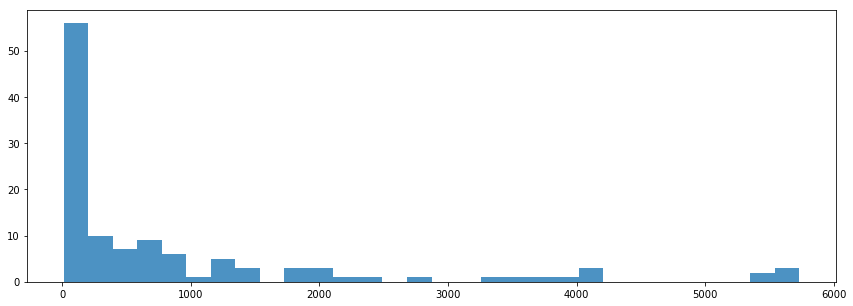

,0.0,0.01,0.05,0.1,0.25,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99,1.0
n_restaurants,12.0,12.0,17.0,25.8,64.5,89.5,143.6,253.0,551.4,843.8,1349.8,2900.0,4157.65,5632.64,5732.0


In [6]:
plt.figure(figsize=(14.5,5))
plt.hist(df['n_restaurants'], bins=30, alpha=0.8)
plt.show()

pd.DataFrame(round(df["n_restaurants"].quantile([0, 0.01, 0.05, .1, .25, .3, .4, .5, .6, .7, .8, .9, .95, .99, 1]),2)).T   


In [7]:
# To get those categories that are above the 25th quantile in terms of number of restaurants.
n_restaurants_threshold = 64 


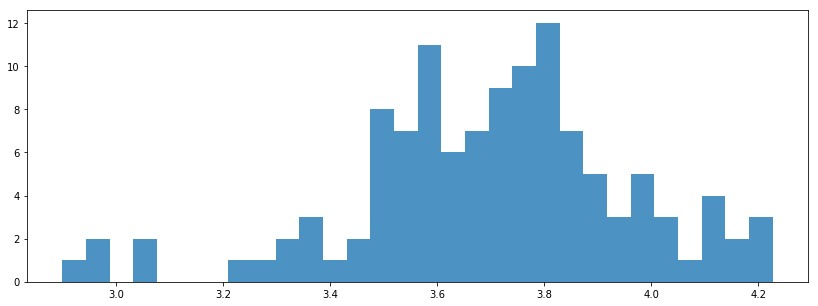

,0.0,0.01,0.05,0.1,0.25,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99,1.0
mean_rating,2.9,2.97,3.27,3.41,3.56,3.58,3.66,3.73,3.78,3.82,3.88,4.02,4.11,4.2,4.23


In [8]:
plt.figure(figsize=(14,5))
plt.hist(df['mean_rating'], bins=30, alpha=0.8)
plt.show()
pd.DataFrame(round(df["mean_rating"].quantile([0, 0.01, 0.05, .1, .25, .3, .4, .5, .6, .7, .8, .9, .95, .99, 1]),2)).T


In [9]:
# To get those categories that are above the 25th quantile in terms of number of ratings
rating_threshold = 3.5


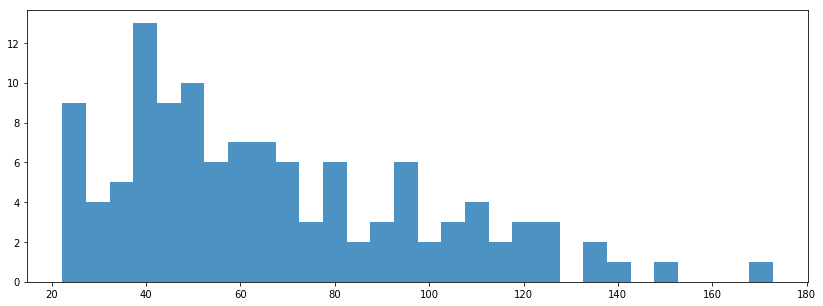

,0.0,0.01,0.05,0.1,0.25,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99,1.0
reviews_per_restaurant,22.27,23.38,26.46,31.41,41.37,45.21,51.12,58.94,67.88,80.51,95.54,116.85,126.02,149.52,172.81


In [10]:
plt.figure(figsize=(14,5))
plt.hist(df['reviews_per_restaurant'], bins=30, alpha=0.8)
plt.show()
pd.DataFrame(round(df["reviews_per_restaurant"].quantile([0, 0.01, 0.05, .1, .25, .3, .4, .5, .6, .7, .8, .9, .95, .99, 1]),2)).T


In [11]:
# To get those categories that are above the 25th quantile in terms of number of restaurants.
reviews_per_restaurant_threshold = 41


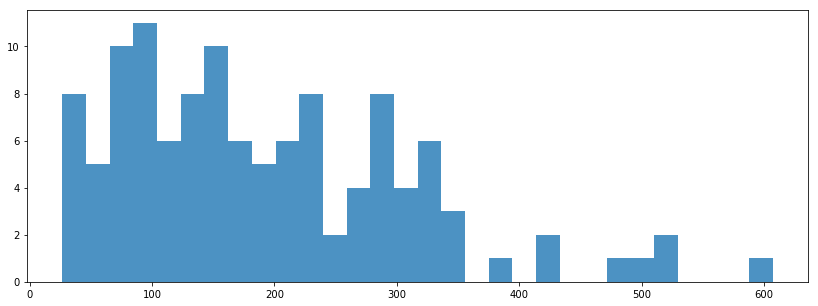

,0.0,0.01,0.05,0.1,0.25,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99,1.0
checkins_per_restaurant,26.89,30.83,42.99,62.44,101.87,107.85,136.38,167.43,213.78,237.82,291.78,328.9,424.94,523.14,606.99


In [12]:
plt.figure(figsize=(14,5))
plt.hist(df['checkins_per_restaurant'], bins=30, alpha=0.8)
plt.show()
pd.DataFrame(round(df["checkins_per_restaurant"].quantile([0, 0.01, 0.05, .1, .25, .3, .4, .5, .6, .7, .8, .9, .95, .99, 1]),2)).T


In [13]:
checkins_per_restaurant_threshold = 101


<a id='reviews'></a>
# 3 Reviews per Restaurant

In [14]:
source = ColumnDataSource(data=dict(
    x = df['reviews_per_restaurant'],
    y = df['mean_rating'],
    desc = df['category'],
))

hover = HoverTool(tooltips=[
    ("desc", "@desc"),
    ("(reviews_per_restaurant, mean_rating)", "($x{(0)}, $y{(0.00)})"),
])

p = figure(plot_width=400, plot_height=400, tools=[hover, "pan","wheel_zoom"], title="Reviews per Restaurant vs Mean Rating")

p.circle('x', 'y', size=15, line_color="navy", fill_color="black", fill_alpha=0.2, source=source)
p.xaxis.axis_label = "reviews_per_restaurant"
p.yaxis.axis_label = "mean_rating"

html = file_html(p, CDN, "Reviews Per Retaurant Scatter")
HTML(html)

<img src="scatter1.PNG">


<a id='checkins'></a>
# 4 Checkins per Restaurant

In [15]:
source = ColumnDataSource(data=dict(
    x = df['checkins_per_restaurant'],
    y = df['mean_rating'],
    desc = df['category'],
))

hover = HoverTool(tooltips=[
    ("desc", "@desc"),
    ("(checkins_per_restaurant, mean_rating)", "($x{(0)}, $y{(0.00)})"),
])

p = figure(plot_width=400, plot_height=400, tools=[hover, "pan","wheel_zoom"], title="Checkins per Restaurant vs Mean Rating")

p.circle('x', 'y', size=15, line_color="navy", fill_color="black", fill_alpha=0.2, source=source)
p.xaxis.axis_label = "checkins_per_restaurant"
p.yaxis.axis_label = "mean_rating"

html = file_html(p, CDN, "Checkins Per Retaurant Scatter")
HTML(html)

<img src="scatter2.PNG">

In [16]:
# Top cuisines to consider:
top_cuisines= df[(df['n_restaurants'] > n_restaurants_threshold) & \
                (df['reviews_per_restaurant'] > reviews_per_restaurant_threshold) &\
                (df['mean_rating'] > rating_threshold) & (df['mean_rating'] < 4) &\
                (df['checkins_per_restaurant'] > checkins_per_restaurant_threshold) ]

top_cuisines = top_cuisines.sort_values(['reviews_per_restaurant'], ascending=[0])
display(top_cuisines)


,category,mean_rating,reviews_per_restaurant,checkins_per_restaurant,n_restaurants
921,Ramen,3.676056,172.809859,606.992958,142
189,Cantonese,3.656716,135.626866,512.343284,67
751,Noodles,3.646947,132.877863,480.980916,262
151,Brazilian,3.668919,126.608108,285.162162,74
31,American (New),3.530478,125.918099,423.772825,3724
1181,Waffles,3.732877,120.890411,319.260274,73
1027,Southern,3.622973,117.145946,299.037838,370
510,Hawaiian,3.834016,116.717213,506.864754,244
1163,Vegetarian,3.861208,109.140534,340.652729,861
972,Seafood,3.571907,106.402062,292.371134,1940


In [17]:
list(top_cuisines["category"])


['Ramen',
 'Cantonese',
 'Noodles',
 'Brazilian',
 'American (New)',
 'Waffles',
 'Southern',
 'Hawaiian',
 'Vegetarian',
 'Seafood',
 'Tapas Bars',
 'Asian Fusion',
 'Breakfast & Brunch',
 'Tacos',
 'Gluten-Free',
 'Sushi Bars',
 'Spanish',
 'Japanese',
 'Soul Food',
 'French',
 'Barbeque',
 'Creperies',
 'Korean',
 'Salad',
 'Thai',
 'Soup',
 'Latin American',
 'Desserts',
 'Mediterranean',
 'Vietnamese',
 'African',
 'Italian',
 'Brasseries',
 'British',
 'Greek',
 'Filipino',
 'Cafes',
 'Lebanese',
 'Food Delivery Services',
 'Juice Bars & Smoothies',
 'Ethnic Food',
 'Middle Eastern']

<a id='google1'></a>
# 5 Google Trend: 5-yr Growth
https://trends.google.com/trends/

This part queries Google Trends data to see the differences among the different categories both in growth and relative search magnitude.

In [85]:
# Cuisines to search based on top cuisines (some names were changed to something queryable in google trends)

lst_cuisine = ['Ramen', 'Cantonese Food', 'Noodles',
 'Brazilian Food', 'American Food', 'Waffles',
 'Southern Food', 'Hawaiian Food', 'Vegetarian', 'Seafood',
 'Tapas Bars', 'Asian Fusion', 'Breakfast & Brunch', 'Tacos',
 'Gluten-Free', 'Sushi Bars', 'Spanish Food', 'Japanese Food',
 'Soul Food', 'French Food', 'Barbeque', 'Creperies',
 'Korean Food', 'Salad', 'Thai Food', 'Soup',
 'Latin American Food', 'Desserts', 'Mediterranean Food', 'Vietnamese Food',
 'African Food', 'Italian Food', 'Brasseries', 'British Food',
 'Greek Food', 'Filipino Food', 'Cafes', 'Lebanese Food', 'Food Delivery Services', 
'Juice Bars & Smoothies', 'Ethnic Food', 'Middle Eastern Food']

In [86]:
def compare_trends(country, lst_cuisine):    
    pytrends = TrendReq(hl='en-US', tz=360)
    final_df = pd.DataFrame()
    group_df = pd.DataFrame()
    
    for cuisine in lst_cuisine:
        new_df = pd.DataFrame()
        pytrends.build_payload(["Ramen",cuisine], cat=0, timeframe='today 5-y', geo=str(country), gprop='')
        temp_df = pytrends.interest_over_time().reset_index()
        temp_df = temp_df[(temp_df["isPartial"] == False) | (temp_df["isPartial"].astype(str) == "False")]
        new_df["date"] = temp_df["date"]
        new_df["cuisine"] = cuisine
        new_df["trend_score"] = temp_df[cuisine]   
        final_df = final_df.append(new_df)
        
        new_group_df = pd.DataFrame()
        new_group_df["cuisine"] = [cuisine]
        group_df_first = pd.DataFrame(new_df.groupby(['cuisine'])['trend_score'].first()).reset_index()
        group_df_last = pd.DataFrame(new_df.groupby(['cuisine'])['trend_score'].last()).reset_index()
        group_df_avg = new_df.groupby(["cuisine"],as_index = False)[["trend_score"]].agg('mean')
        display(group_df_avg)            

        new_group_df["first_trend_score"] = group_df_first["trend_score"]
        new_group_df["last_trend_score"] = group_df_last["trend_score"]
        new_group_df["avg_score"] = group_df_avg["trend_score"]
        new_group_df["5-yr Growth"] = round(new_group_df["last_trend_score"]/new_group_df["first_trend_score"],2)
        
        group_df = group_df.append(new_group_df)        
        
    return final_df.reset_index(), group_df.reset_index()

compare_df, compare_group_df = compare_trends('US', lst_cuisine)

compare_df


,cuisine,trend_score
0,Ramen,45.673077


,cuisine,trend_score
0,Cantonese Food,0


,cuisine,trend_score
0,Noodles,66.65


,cuisine,trend_score
0,Brazilian Food,1.038462


,cuisine,trend_score
0,American Food,8.538462


,cuisine,trend_score
0,Waffles,27.557692


,cuisine,trend_score
0,Southern Food,3.542308


,cuisine,trend_score
0,Hawaiian Food,1.961538


,cuisine,trend_score
0,Vegetarian,57.826923


,cuisine,trend_score
0,Seafood,53.046154


,cuisine,trend_score
0,Tapas Bars,0


,cuisine,trend_score
0,Asian Fusion,2.338462


,cuisine,trend_score
0,Breakfast & Brunch,0


,cuisine,trend_score
0,Tacos,12.865385


,cuisine,trend_score
0,Gluten-Free,1.557692


,cuisine,trend_score
0,Sushi Bars,0.246154


,cuisine,trend_score
0,Spanish Food,5.888462


,cuisine,trend_score
0,Japanese Food,5.423077


,cuisine,trend_score
0,Soul Food,13.95


,cuisine,trend_score
0,French Food,5


,cuisine,trend_score
0,Barbeque,13.684615


,cuisine,trend_score
0,Creperies,0


,cuisine,trend_score
0,Korean Food,4.303846


,cuisine,trend_score
0,Salad,53.5


,cuisine,trend_score
0,Thai Food,20.888462


,cuisine,trend_score
0,Soup,48.176923


,cuisine,trend_score
0,Latin American Food,0


,cuisine,trend_score
0,Desserts,46.192308


,cuisine,trend_score
0,Mediterranean Food,3.557692


,cuisine,trend_score
0,Vietnamese Food,3.603846


,cuisine,trend_score
0,African Food,2.034615


,cuisine,trend_score
0,Italian Food,10.173077


,cuisine,trend_score
0,Brasseries,0


,cuisine,trend_score
0,British Food,1.023077


,cuisine,trend_score
0,Greek Food,5.407692


,cuisine,trend_score
0,Filipino Food,1.884615


,cuisine,trend_score
0,Cafes,5.369231


,cuisine,trend_score
0,Lebanese Food,1.011538


,cuisine,trend_score
0,Food Delivery Services,0.407692


,cuisine,trend_score
0,Juice Bars & Smoothies,0


,cuisine,trend_score
0,Ethnic Food,0.776923


,cuisine,trend_score
0,Middle Eastern Food,1.130769


,index,date,cuisine,trend_score
0,0,2012-12-16,Ramen,23
1,1,2012-12-23,Ramen,26
2,2,2012-12-30,Ramen,30
3,3,2013-01-06,Ramen,26
4,4,2013-01-13,Ramen,26
5,5,2013-01-20,Ramen,29
6,6,2013-01-27,Ramen,27
7,7,2013-02-03,Ramen,25
8,8,2013-02-10,Ramen,25
9,9,2013-02-17,Ramen,26


In [87]:
compare_group_df.sort_values(by = "5-yr Growth", ascending = False)


,index,cuisine,first_trend_score,last_trend_score,avg_score,5-yr Growth
38,0,Food Delivery Services,0,1,0.407692,inf
0,0,Ramen,23,78,45.673077,3.390000
35,0,Filipino Food,1,3,1.884615,3.000000
13,0,Tacos,6,16,12.865385,2.670000
29,0,Vietnamese Food,2,5,3.603846,2.500000
28,0,Mediterranean Food,2,5,3.557692,2.500000
18,0,Soul Food,8,17,13.950000,2.120000
36,0,Cafes,3,6,5.369231,2.000000
7,0,Hawaiian Food,1,2,1.961538,2.000000
16,0,Spanish Food,5,9,5.888462,1.800000


In [88]:
source = ColumnDataSource(data=dict(
    x = compare_group_df['5-yr Growth'],
    y = compare_group_df['avg_score'],
    desc = compare_group_df['cuisine'],
))

hover = HoverTool(tooltips=[
    ("cuisine", "@desc"),
    ("(5-yr Growth, avg_score)", "($x{(0)}, $y{(0.00)})"),
])

p = figure(plot_width=400, plot_height=400, tools=[hover, "pan","wheel_zoom"], title="Google trends")

p.circle('x', 'y', size=25, line_color="black", fill_color="black", fill_alpha=0.2, source=source)
p.xaxis.axis_label = "5-yr Growth"
p.yaxis.axis_label = "Volume"

html = file_html(p, CDN, "my plot")
HTML(html)

<img src="scatter3.PNG">


Clearly Ramen is a winner. Tacos is growing however its relative search volume magnitude is lower than Ramen. Noodles seems to be stale although with a higher market size. Filipino Food is growing fast, however too small market. Finally Thai and Sould Food are just not good enough in comparison.

In [89]:
a = "Ramen"
b = "Tacos"
c = "Noodles"

trace_1 = go.Scatter(
    x=compare_df.loc[compare_df['cuisine'] == a].date,
    y=compare_df.loc[compare_df['cuisine'] == a]['trend_score'],
    name = a,
    line = dict(color = '#1f77b4'),
    opacity = 0.8)

trace_2 = go.Scatter(
    x=compare_df.loc[compare_df['cuisine'] == b].date,
    y=compare_df.loc[compare_df['cuisine'] == b]['trend_score'],
    name = b,
    line = dict(color = '#c9640a'),
    opacity = 0.8)

trace_3 = go.Scatter(
    x=compare_df.loc[compare_df['cuisine'] == c].date,
    y=compare_df.loc[compare_df['cuisine'] == c]['trend_score'],
    name = c,
    line = dict(color = '#9d9d9d'),
    opacity = 0.8)


data = [trace_1, trace_2, trace_3]

layout = dict(
    title='Time Series with Rangeslider',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(),
        type='date'
    )
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename = "Cuisine Comparison Time Series")

Noodles has been growing but not as fast as Ramen. Furthermore it's a market that seems to be more saturated and hence Ramen is a clear opportunity.

<a id='where'></a>
# 6. Location

Similar as to what we did before, but this time we want to see the differences among the States, but only for the Ramen cuisine.

In [105]:
def get_states_trends(lst_states, keyword):
    pytrends = TrendReq(hl='en-US', tz=360)
    kw_list = [keyword]
    final_df = pd.DataFrame()
    group_df = pd.DataFrame()
    
    for state in lst_states:
        new_df = pd.DataFrame()
        pytrends.build_payload(kw_list, cat=0, timeframe='today 5-y', geo=str(state), gprop='')  
        temp_df = pytrends.interest_over_time().reset_index()
        temp_df = temp_df[temp_df["isPartial"] == False]
        new_df["date"] = temp_df["date"]
        new_df["state"] = state    
        new_df["trend_score"] = temp_df[keyword]        
        final_df = final_df.append(new_df)
        
        new_group_df = pd.DataFrame()
        new_group_df["state"] = [state]
        group_df_first = pd.DataFrame(new_df.groupby(['state'])['trend_score'].first()).reset_index()
        group_df_last = pd.DataFrame(new_df.groupby(['state'])['trend_score'].last()).reset_index()
        new_group_df["first_trend_score"] = group_df_first["trend_score"]
        new_group_df["last_trend_score"] = group_df_last["trend_score"]
        new_group_df["5-yr Growth"] = round(new_group_df["last_trend_score"]/new_group_df["first_trend_score"],2)
        group_df = group_df.append(new_group_df)        
        
        
    return final_df.reset_index(), group_df.reset_index()

lst_states = ['CA-ON', 'US-OH', 'CA-QC', 'US-PA', 'US-AZ', 'US-NV', 'US-NC', 'US-IL', 'US-WI']

final_df, group_df = get_states_trends(lst_states, 'Ramen')

display(final_df)

group_df = group_df.sort_values(['5-yr Growth'], ascending=[0])
group_df


,index,date,state,trend_score
0,0,2012-11-25,CA-ON,38
1,1,2012-12-02,CA-ON,29
2,2,2012-12-09,CA-ON,29
3,3,2012-12-16,CA-ON,36
4,4,2012-12-23,CA-ON,31
5,5,2012-12-30,CA-ON,42
6,6,2013-01-06,CA-ON,36
7,7,2013-01-13,CA-ON,38
8,8,2013-01-20,CA-ON,35
9,9,2013-01-27,CA-ON,35


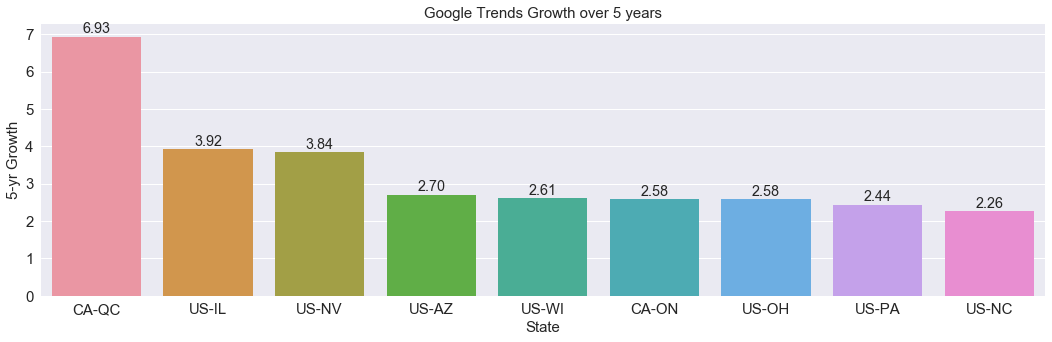

In [108]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 5)
    
ax = sns.barplot(ax = ax, x="state", y="5-yr Growth", data=group_df)

ax.axes.set_title("Google Trends Growth over 5 years",fontsize=15)
ax.set_xlabel("State",fontsize=15)
ax.set_ylabel("5-yr Growth",fontsize=15)
ax.tick_params(labelsize=15)
sns.set(font_scale=1.2)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+0.1,
            '{:1.2f}'.format(height),
            ha="center") 



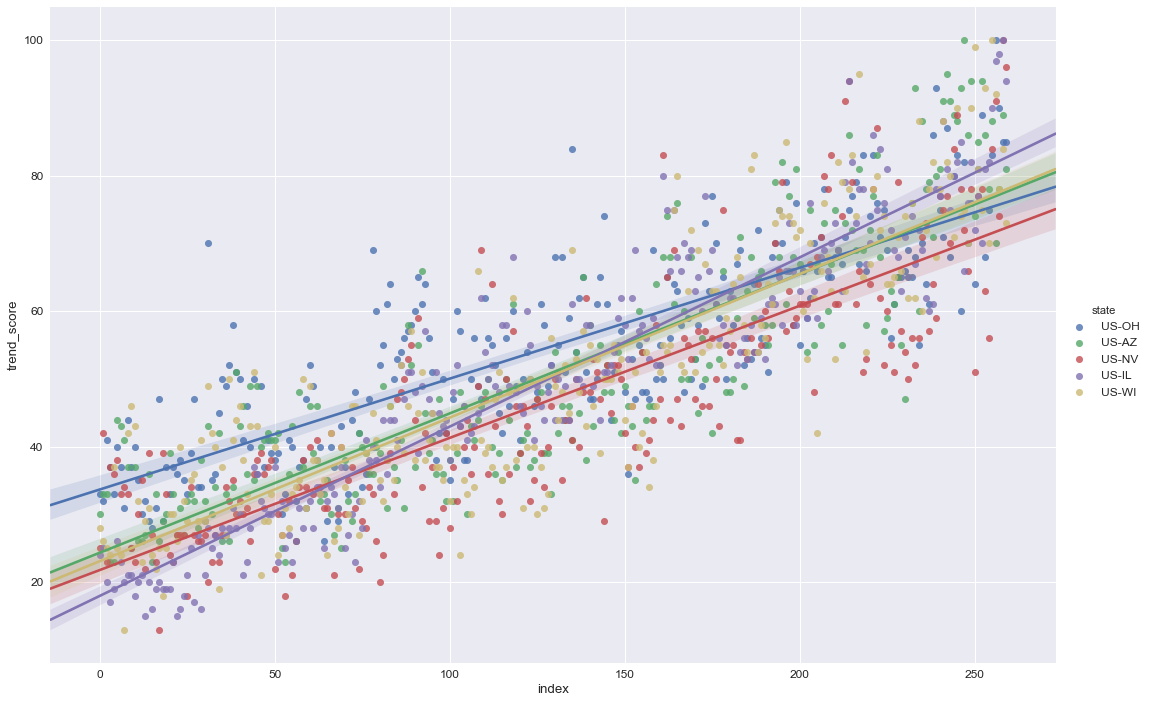

In [110]:

sns.lmplot('index', 'trend_score', hue='state', data=final_df.loc[
    (final_df['state'] == "US-NV") | (final_df['state'] == "US-AZ") | (final_df['state'] == "US-IL") \
    | (final_df['state'] == "US-OH") | (final_df['state'] == "US-WI") 
], sharex=True, size = 10, aspect = 1.5,  scatter_kws={"s": 50})



It seems that ILLINOIS is the strongest State to pursue with a Ramen Restaurant Chain.